# Classification

In [9]:
# common imports
from collections import defaultdict
import os
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter

# local imports
import dataset as custom_dataset
import losses
import model as custom_models
from plotting import plot_umap, create_gif_from_rgb_list, display_gif, plot_image_grid

# enable inline plotting 
%matplotlib inline
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
datasets = {"mnist":[28,1,True], "cifar10":[32,3, True], "fer2013":[48,1, False]}
dataset_name = "cifar10" 
dataset_image_size, dataset_image_channels, dataset_test_labels_available = datasets[dataset_name]
# common objects
test_dataset = custom_dataset.choose_test_dataset(dataset_name=dataset_name)

# define device
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


In [3]:
@torch.no_grad()
def compute_embeddings(model, dataset, device, labels_available=True, embedding_dim=256, batch_size=64):
    dataset_len = len(dataset)
    out_embeddings = np.zeros((dataset_len, embedding_dim))
    if labels_available:
        out_labels = np.zeros((dataset_len))
    else:
        out_labels = None

    dataloader = DataLoader(dataset, 
                            batch_size=batch_size,
                            num_workers=4,
                            shuffle=False)
    model.to(device)
    model.eval()
    for i, data in enumerate(dataloader):
        img, label = data
        img, label = img.to(device), label.to(device)
        # compute embedding 
        x = model(img) #[1, 1, H, W] -> [1, d]
        # append to list
        out_embeddings[i*batch_size:(i+1)*batch_size, :] = x.cpu().numpy()
        if labels_available:
            out_labels[i*batch_size:(i+1)*batch_size] = label.cpu().numpy() #[B]
    return out_embeddings, out_labels

In [4]:
num_epochs = 30
batch_size = 64
num_workers = 2
learning_rate = 1e-4
print_freq = 500 # minibatches

## Classification without Center Loss

In [5]:
# Define a log directory for TensorBoard
log_dir = "./logs/classification"

# Create a SummaryWriter
writer = SummaryWriter(log_dir)

# Start TensorBoard
%tensorboard --logdir ./logs/classification

Files already downloaded and verified
[Epoch: 0, Batch: 499] Loss: 0.8236


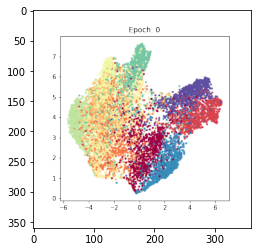

[Epoch: 0] Average Precision: 72.9900
[Epoch: 1, Batch: 217] Loss: 1.1323
[Epoch: 1, Batch: 717] Loss: 0.7781


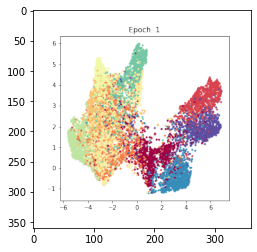

[Epoch: 1] Average Precision: 75.2400
[Epoch: 2, Batch: 435] Loss: 0.4780


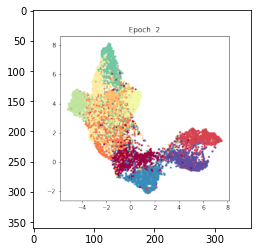

[Epoch: 2] Average Precision: 72.2400
[Epoch: 3, Batch: 153] Loss: 0.6136
[Epoch: 3, Batch: 653] Loss: 0.6148


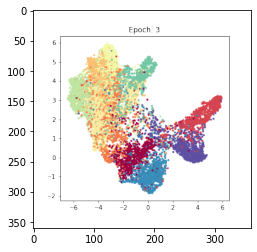

[Epoch: 3] Average Precision: 67.3900
[Epoch: 4, Batch: 371] Loss: 0.3154


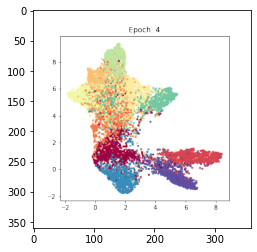

[Epoch: 4] Average Precision: 72.0600
[Epoch: 5, Batch: 89] Loss: 0.5174
[Epoch: 5, Batch: 589] Loss: 0.3985


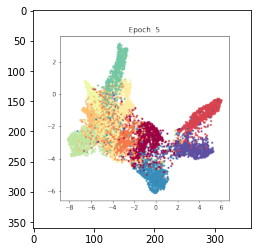

[Epoch: 5] Average Precision: 79.4200
[Epoch: 6, Batch: 307] Loss: 0.2872


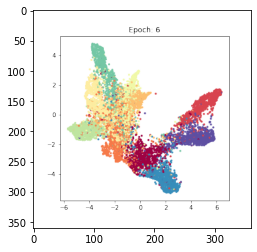

[Epoch: 6] Average Precision: 75.6600
[Epoch: 7, Batch: 25] Loss: 0.3279
[Epoch: 7, Batch: 525] Loss: 0.3090


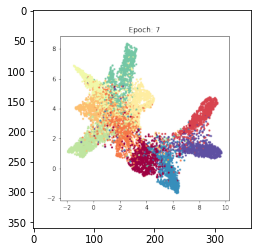

[Epoch: 7] Average Precision: 81.9500
[Epoch: 8, Batch: 243] Loss: 0.4345
[Epoch: 8, Batch: 743] Loss: 0.1142


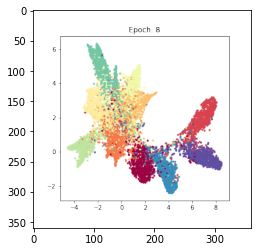

[Epoch: 8] Average Precision: 81.3700
[Epoch: 9, Batch: 461] Loss: 0.1102


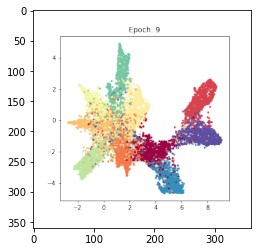

[Epoch: 9] Average Precision: 80.0300
[Epoch: 10, Batch: 179] Loss: 0.2724
[Epoch: 10, Batch: 679] Loss: 0.1844


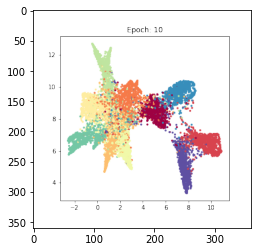

[Epoch: 10] Average Precision: 83.2900
[Epoch: 11, Batch: 397] Loss: 0.2052


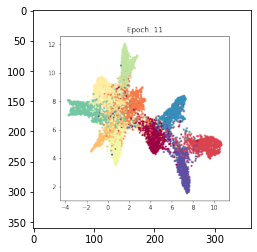

[Epoch: 11] Average Precision: 83.9600
[Epoch: 12, Batch: 115] Loss: 0.4321
[Epoch: 12, Batch: 615] Loss: 0.0374


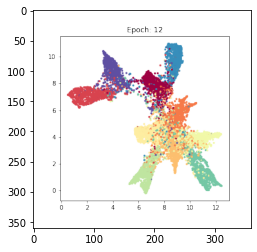

[Epoch: 12] Average Precision: 81.7600
[Epoch: 13, Batch: 333] Loss: 0.1170


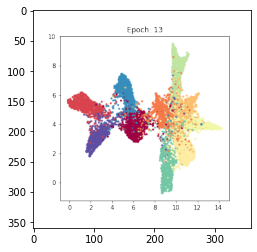

[Epoch: 13] Average Precision: 80.3100
[Epoch: 14, Batch: 51] Loss: 0.2311
[Epoch: 14, Batch: 551] Loss: 0.3295


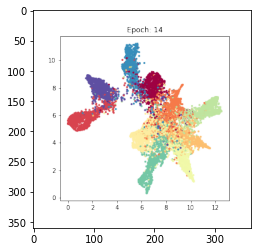

[Epoch: 14] Average Precision: 80.0800
[Epoch: 15, Batch: 269] Loss: 0.1411
[Epoch: 15, Batch: 769] Loss: 0.1334


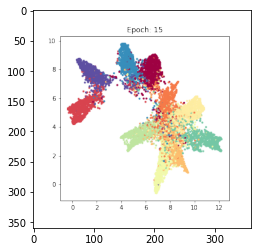

[Epoch: 15] Average Precision: 79.0500
[Epoch: 16, Batch: 487] Loss: 0.1536


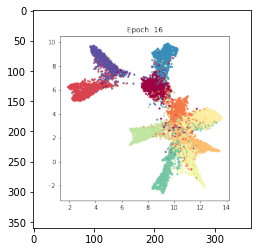

[Epoch: 16] Average Precision: 83.1700
[Epoch: 17, Batch: 205] Loss: 0.0376
[Epoch: 17, Batch: 705] Loss: 0.0235


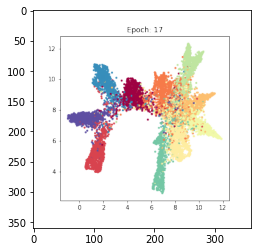

[Epoch: 17] Average Precision: 82.3700
[Epoch: 18, Batch: 423] Loss: 0.0056


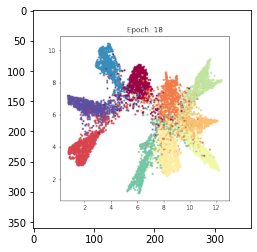

[Epoch: 18] Average Precision: 86.7000
[Epoch: 19, Batch: 141] Loss: 0.0140
[Epoch: 19, Batch: 641] Loss: 0.1839


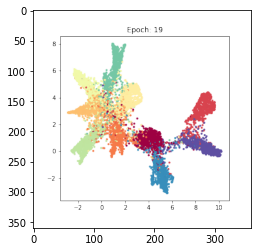

[Epoch: 19] Average Precision: 86.4700
[Epoch: 20, Batch: 359] Loss: 0.0006


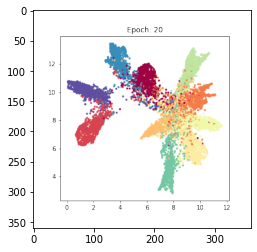

[Epoch: 20] Average Precision: 86.9400
[Epoch: 21, Batch: 77] Loss: 0.0003
[Epoch: 21, Batch: 577] Loss: 0.0012


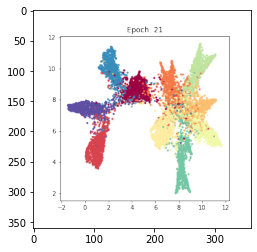

[Epoch: 21] Average Precision: 86.9200
[Epoch: 22, Batch: 295] Loss: 0.0619


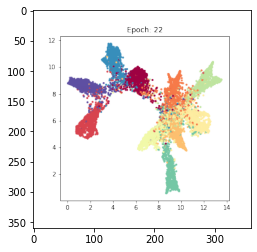

[Epoch: 22] Average Precision: 87.3400
[Epoch: 23, Batch: 13] Loss: 0.0019
[Epoch: 23, Batch: 513] Loss: 0.0000


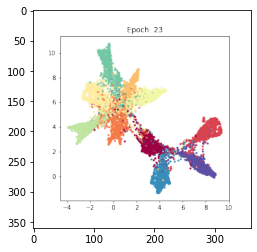

[Epoch: 23] Average Precision: 87.8000
[Epoch: 24, Batch: 231] Loss: 0.0000
[Epoch: 24, Batch: 731] Loss: 0.0000


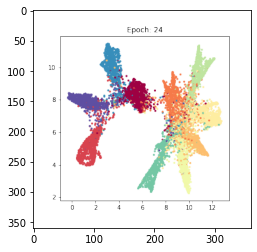

[Epoch: 24] Average Precision: 88.2700
[Epoch: 25, Batch: 449] Loss: 0.0000


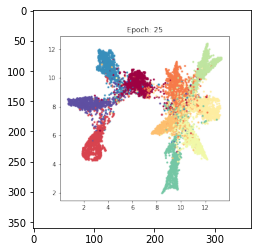

[Epoch: 25] Average Precision: 88.1100
[Epoch: 26, Batch: 167] Loss: 0.0000
[Epoch: 26, Batch: 667] Loss: 0.0000


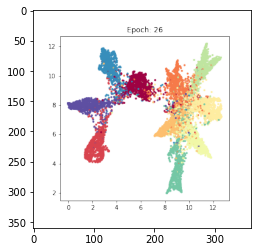

[Epoch: 26] Average Precision: 88.1900
[Epoch: 27, Batch: 385] Loss: 0.0000


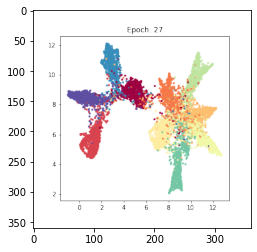

[Epoch: 27] Average Precision: 88.2000
[Epoch: 28, Batch: 103] Loss: 0.0000
[Epoch: 28, Batch: 603] Loss: 0.0000


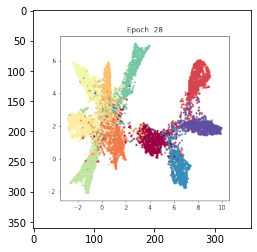

[Epoch: 28] Average Precision: 88.2100
[Epoch: 29, Batch: 321] Loss: 0.0000


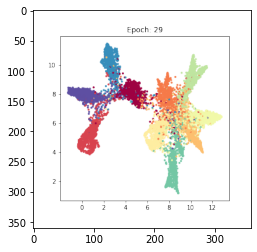

[Epoch: 29] Average Precision: 88.2200


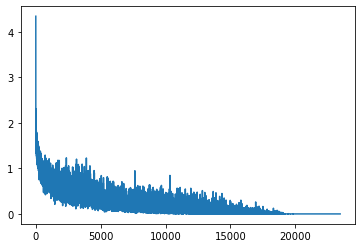

In [6]:
# instantiate model, dataset, dataloader, optimizer
dataset = custom_dataset.Classification_Dataset(dataset_name=dataset_name)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

# base_model = model.SimpleCNN(in_channels=dataset_image_channels,
#                         input_img_size=dataset_image_size)
base_model = custom_model.ResNet9(dataset_image_channels, dataset.num_classes)
base_model = base_model.to(device)
embedding_dim = base_model.out

classification_head = nn.Linear(embedding_dim, dataset.num_classes, bias=False)
model = nn.Sequential(base_model, classification_head)
model.to(device)

criterion = losses.Classification_Loss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate )
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
                                                steps_per_epoch=len(dataloader),
                                               epochs=num_epochs)
loss_history = []
step = 0

# train loop
for epoch in range(num_epochs):    
    model.train()
    running_loss = 0.0
    for i_batch, data in enumerate(dataloader):
        img, gt_label = data
        bs = img.shape[0]
        
        # send data to device
        img, gt_label = img.to(device), gt_label.to(device)

        # predict using model
        x = model(img)

        # compute loss, backward, update optimizer
        loss = criterion(x, gt_label)
        
        running_loss += loss.item()        
        
        loss_history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print stuff
        step += 1
        if step % print_freq == 0:
            print("[Epoch: %d, Batch: %d] Loss: %0.4f"%(epoch, i_batch, loss.item()))
            writer.add_scalar('total loss', running_loss / print_freq, step)
            writer.add_scalar('lr', scheduler.get_last_lr()[0], step)
            running_loss = 0.0       
        

    # testing loop
    model.eval()
    base_model.eval()
    test_embeddings, test_labels = compute_embeddings(base_model,
                                                      test_dataset,
                                                      device,
                                                      embedding_dim=embedding_dim, 
                                                      labels_available=dataset_test_labels_available)
    
    title = "Epoch: %d"%(epoch)
    i_plot = plot_umap(test_embeddings, test_labels, title=title)
    plt.imshow(i_plot)
    plt.show()
    plt.close()
                                                      
    # compute average precision
    test_embeddings = torch.from_numpy(test_embeddings).to(device).float() #[B, d]
    test_labels = torch.from_numpy(test_labels).to(device) #[B]
    N = test_embeddings.shape[0]
    p = 0
    with torch.no_grad():
        for i in range(N//batch_size + 1):
            start, end = i*batch_size, (i+1)*batch_size
            if end >= N: 
              end = N-1
              if start == end:
                  break
            i_score = classification_head(test_embeddings[start:end,:])
            i_label = test_labels[start:end]
            # compute precision
            num_correct = torch.sum((torch.argmax(i_score, dim = -1) == i_label)).item()
            p+= num_correct

    av_p = (p / N) * 100
    
    # log av precision 
    print("[Epoch: %d] Average Precision: %0.4f"%(epoch, av_p))
    writer.add_scalar('average precision', av_p, epoch)        

# plot loss
fig = plt.figure()
plt.plot(loss_history)
plt.show()
plt.close(fig)


---
## Classification with Center Loss

In [7]:
# Define a log directory for TensorBoard
log_dir = "./logs/classification_with_center_loss"

# Create a SummaryWriter
writer = SummaryWriter(log_dir)

# Start TensorBoard
%tensorboard --logdir ./logs/classification_with_center_loss

Files already downloaded and verified
[Epoch: 0, Batch: 499] Loss: 0.8195


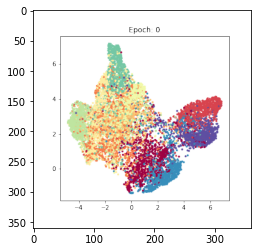

[Epoch: 0] Average Precision: 72.8000
[Epoch: 1, Batch: 217] Loss: 0.8569
[Epoch: 1, Batch: 717] Loss: 0.6673


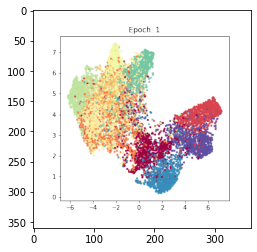

[Epoch: 1] Average Precision: 71.7500
[Epoch: 2, Batch: 435] Loss: 1.4797


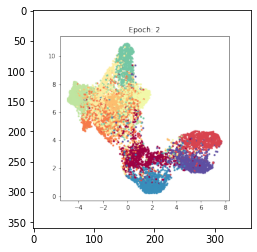

[Epoch: 2] Average Precision: 78.1200
[Epoch: 3, Batch: 153] Loss: 0.9995
[Epoch: 3, Batch: 653] Loss: 0.9682


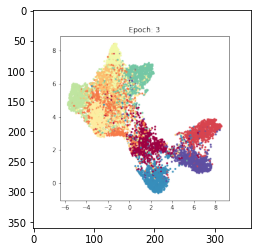

[Epoch: 3] Average Precision: 81.1700
[Epoch: 4, Batch: 371] Loss: 0.7678


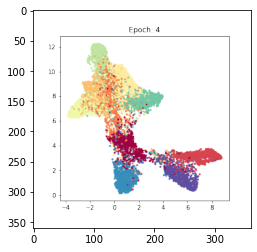

[Epoch: 4] Average Precision: 80.7200
[Epoch: 5, Batch: 89] Loss: 0.8793
[Epoch: 5, Batch: 589] Loss: 0.8660


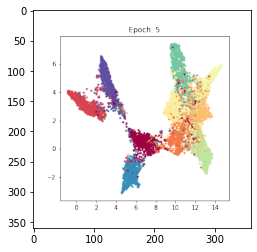

[Epoch: 5] Average Precision: 75.7500
[Epoch: 6, Batch: 307] Loss: 0.6413


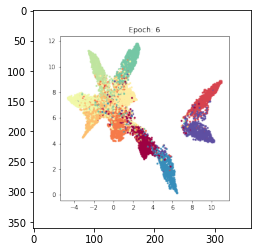

[Epoch: 6] Average Precision: 76.5400
[Epoch: 7, Batch: 25] Loss: 0.6385
[Epoch: 7, Batch: 525] Loss: 0.6865


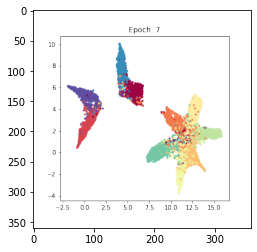

[Epoch: 7] Average Precision: 82.5200
[Epoch: 8, Batch: 243] Loss: 0.6346
[Epoch: 8, Batch: 743] Loss: 0.6258


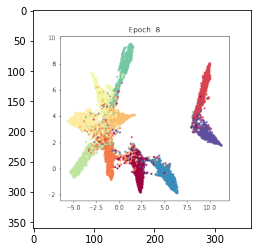

[Epoch: 8] Average Precision: 83.0800
[Epoch: 9, Batch: 461] Loss: 0.5841


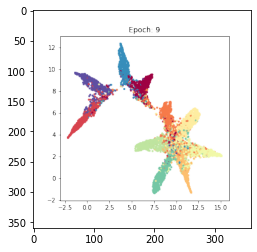

[Epoch: 9] Average Precision: 80.7100
[Epoch: 10, Batch: 179] Loss: 0.5482
[Epoch: 10, Batch: 679] Loss: 0.5820


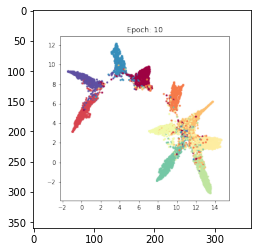

[Epoch: 10] Average Precision: 83.8900
[Epoch: 11, Batch: 397] Loss: 0.5527


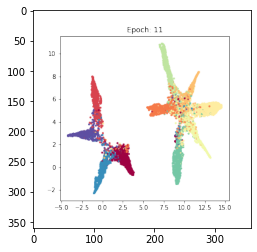

[Epoch: 11] Average Precision: 84.5200
[Epoch: 12, Batch: 115] Loss: 0.5868
[Epoch: 12, Batch: 615] Loss: 0.5703


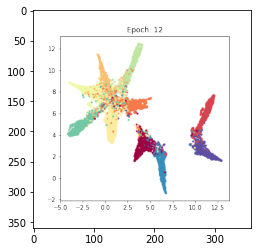

[Epoch: 12] Average Precision: 84.4400
[Epoch: 13, Batch: 333] Loss: 0.5173


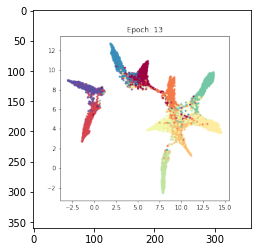

[Epoch: 13] Average Precision: 85.0800
[Epoch: 14, Batch: 51] Loss: 0.5466
[Epoch: 14, Batch: 551] Loss: 0.5434


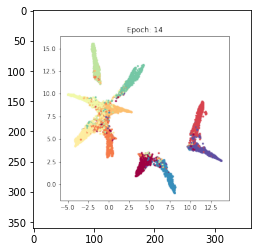

[Epoch: 14] Average Precision: 86.7300
[Epoch: 15, Batch: 269] Loss: 0.5536
[Epoch: 15, Batch: 769] Loss: 0.5051


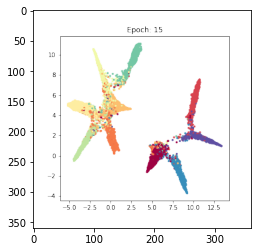

[Epoch: 15] Average Precision: 86.1500
[Epoch: 16, Batch: 487] Loss: 0.5189


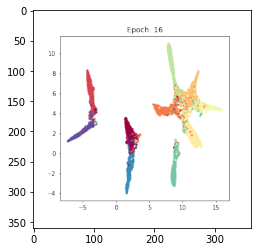

[Epoch: 16] Average Precision: 86.9400
[Epoch: 17, Batch: 205] Loss: 0.4964
[Epoch: 17, Batch: 705] Loss: 0.5067


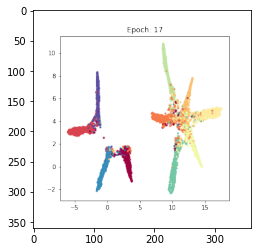

[Epoch: 17] Average Precision: 87.0300
[Epoch: 18, Batch: 423] Loss: 0.4928


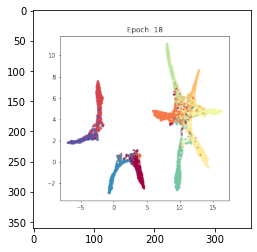

[Epoch: 18] Average Precision: 88.6400
[Epoch: 19, Batch: 141] Loss: 0.4820
[Epoch: 19, Batch: 641] Loss: 0.4775


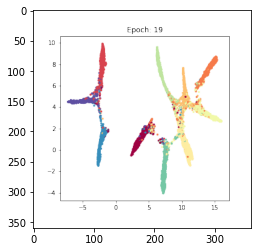

[Epoch: 19] Average Precision: 88.4100
[Epoch: 20, Batch: 359] Loss: 0.4727


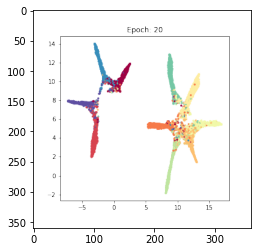

[Epoch: 20] Average Precision: 88.7100
[Epoch: 21, Batch: 77] Loss: 0.4837
[Epoch: 21, Batch: 577] Loss: 0.4672


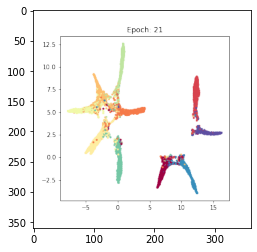

[Epoch: 21] Average Precision: 88.7600
[Epoch: 22, Batch: 295] Loss: 0.4718


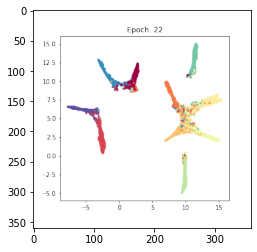

[Epoch: 22] Average Precision: 88.6000
[Epoch: 23, Batch: 13] Loss: 0.4692
[Epoch: 23, Batch: 513] Loss: 0.4624


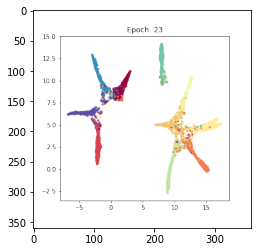

[Epoch: 23] Average Precision: 88.9700
[Epoch: 24, Batch: 231] Loss: 0.4624
[Epoch: 24, Batch: 731] Loss: 0.4674


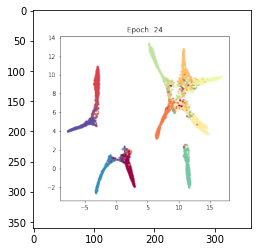

[Epoch: 24] Average Precision: 88.8200
[Epoch: 25, Batch: 449] Loss: 0.4595


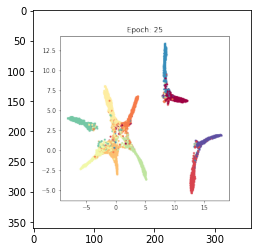

[Epoch: 25] Average Precision: 88.5600
[Epoch: 26, Batch: 167] Loss: 0.4613
[Epoch: 26, Batch: 667] Loss: 0.4662


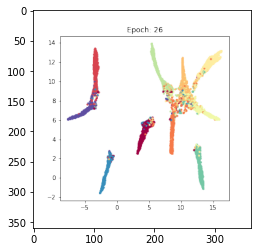

[Epoch: 26] Average Precision: 88.7800
[Epoch: 27, Batch: 385] Loss: 0.4620


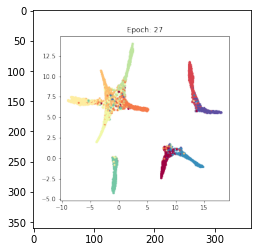

[Epoch: 27] Average Precision: 88.7300
[Epoch: 28, Batch: 103] Loss: 0.4639
[Epoch: 28, Batch: 603] Loss: 0.4653


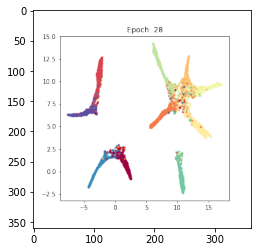

[Epoch: 28] Average Precision: 88.8100
[Epoch: 29, Batch: 321] Loss: 0.4617


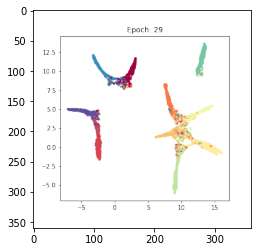

[Epoch: 29] Average Precision: 88.8600


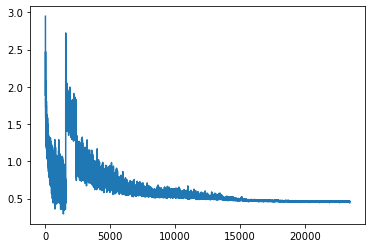

In [10]:
# instantiate model, dataset, dataloader, optimizer
dataset = custom_dataset.Classification_Dataset(dataset_name=dataset_name)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

base_model = custom_models.ResNet9(dataset_image_channels, dataset.num_classes)
base_model = base_model.to(device)
embedding_dim = base_model.out

classification_head = nn.Linear(embedding_dim, dataset.num_classes, bias=False)
model = nn.Sequential(base_model, classification_head)
model.to(device)

criterion = losses.Classification_Loss().to(device)
criterion_center_loss = losses.Center_Loss().to(device)
wt_center = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate )
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
                                                steps_per_epoch=len(dataloader),
                                               epochs=num_epochs)

umap_plots = []
loss_history = []
step = 0
class_centers = {}

# train loop
for epoch in range(num_epochs):    
    class_wise_train_embeddings = defaultdict(list)    
    model.train()
    running_loss = 0.0
    running_center_loss = 0.0
    for i_batch, data in enumerate(dataloader):
        img, gt_label = data
        bs = img.shape[0]
        
        # send data to device
        img, gt_label = img.to(device), gt_label.to(device)

        # predict using model
        x = model(img)
    
        # append the class embeddings to class_wise_train_embeddings
        for i in range(bs):
            class_wise_train_embeddings[gt_label[i].item()].append(x[i].clone().detach())

        # compute loss, backward, update optimizer
        loss = criterion(x, gt_label)
        
        # compute center loss
        if epoch > 1:
            # make centers
            this_batch_centers = []
            for i in range(bs):
                this_batch_centers.append(class_centers[gt_label[i].item()])
            this_batch_centers = torch.stack(this_batch_centers).to(device)
            # compute loss
            center_loss = criterion_center_loss(x, this_batch_centers)

            # add to main loss
            loss = loss + wt_center * center_loss
            running_center_loss += center_loss.item()
        
        running_loss += loss.item()        
        
        loss_history.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print stuff
        step += 1
        if step % print_freq == 0:
            print("[Epoch: %d, Batch: %d] Loss: %0.4f"%(epoch, i_batch, loss.item()))
            writer.add_scalar('total loss', running_loss / print_freq, step)
            writer.add_scalar('center loss', running_center_loss / print_freq, step)
            writer.add_scalar('lr', scheduler.get_last_lr()[0], step)
            running_loss = 0.0
            running_center_loss = 0.0
        
    # update class centers
    for key, val in class_wise_train_embeddings.items():
        c = torch.mean(torch.stack(val), dim = 0).unsqueeze(0)
        class_centers[key] = c.to(device) 

    # testing loop
    model.eval()
    base_model.eval()
    test_embeddings, test_labels = compute_embeddings(base_model,
                                                      test_dataset,
                                                      device,
                                                      embedding_dim=embedding_dim, 
                                                      labels_available=dataset_test_labels_available)
    
    title = "Epoch: %d"%(epoch)
    i_plot = plot_umap(test_embeddings, test_labels, title=title)
#     umap_plots.append(i_plot)
    plt.imshow(i_plot)
    plt.show()
    plt.close()
                                                      
    # compute average precision
    test_embeddings = torch.from_numpy(test_embeddings).to(device).float() #[B, d]
    test_labels = torch.from_numpy(test_labels).to(device) #[B]
    N = test_embeddings.shape[0]
    p = 0
    with torch.no_grad():
        for i in range(N//batch_size + 1):
            start, end = i*batch_size, (i+1)*batch_size
            if end >= N: 
              end = N-1
              if start == end:
                  break
            i_score = classification_head(test_embeddings[start:end,:])
            i_label = test_labels[start:end]
            # compute precision
            num_correct = torch.sum((torch.argmax(i_score, dim = -1) == i_label)).item()
            p+= num_correct

    av_p = (p / N) * 100
    
    # log av precision 
    print("[Epoch: %d] Average Precision: %0.4f"%(epoch, av_p))
    writer.add_scalar('average precision', av_p, epoch)        

# plot loss
fig = plt.figure()
plt.plot(loss_history)
plt.show()
plt.close(fig)

### Take-Away
For classification, using center loss results in compaction of clusters as opposed to vanilla CE Loss. The Loss curves are also more stable for center loss.w